In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
num_train = len(train_data)
indices = list(range(num_train)) # Make a list of all training samples
np.random.shuffle(indices) # shuffle training samples
split = int(np.floor(valid_size * num_train))
train_dix, valid_dix = indices[split:], indices[:split]

In [5]:
train_sampler = SubsetRandomSampler(train_dix)
valid_sampler = SubsetRandomSampler(valid_dix)
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

In [6]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

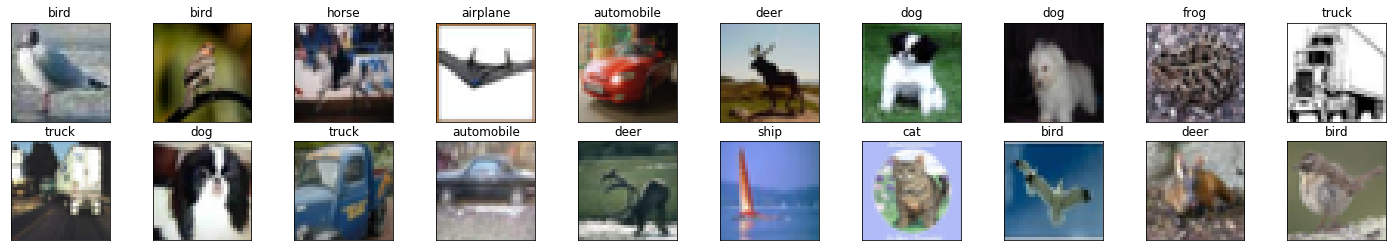

In [8]:

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [9]:
# Archetecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # 16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # (8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        # Linear layers
        self.fc1 = nn.Linear(1024, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        # Flatten image
        x = x.view(-1, 1024)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        

In [10]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [11]:
if train_on_gpu:
    model.cuda()

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [13]:
n_epochs = 20
valid_loss_min = np.Inf # infinity track validation loss

for epoch in range(n_epochs):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target) # compare lable with estimated label
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    '''
    # Validate model
    '''
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print("Epoch:{} \tTrain_Loss:{} \tValidation_Loss:{}".format(epoch, train_loss, valid_loss))

Epoch:0 	Train_Loss:2.1011331707835197 	Validation_Loss:1.7956251139640809
Epoch:1 	Train_Loss:1.6224799951314925 	Validation_Loss:1.468559925198555
Epoch:2 	Train_Loss:1.4067373012304305 	Validation_Loss:1.3071552278995513
Epoch:3 	Train_Loss:1.2765118485689164 	Validation_Loss:1.2309867802858352
Epoch:4 	Train_Loss:1.1567142941504718 	Validation_Loss:1.1067676866054534
Epoch:5 	Train_Loss:1.0537324247211217 	Validation_Loss:1.0888953610658645
Epoch:6 	Train_Loss:0.9675400245934724 	Validation_Loss:1.007468480169773
Epoch:7 	Train_Loss:0.8909592094123363 	Validation_Loss:0.9407552654147148
Epoch:8 	Train_Loss:0.823352164208889 	Validation_Loss:0.8987324094772339
Epoch:9 	Train_Loss:0.7557368087992072 	Validation_Loss:0.9241588014960289
Epoch:10 	Train_Loss:0.6940341037362814 	Validation_Loss:0.8466351179480552
Epoch:11 	Train_Loss:0.6378651110157371 	Validation_Loss:0.8660426270663738
Epoch:12 	Train_Loss:0.5760113250166178 	Validation_Loss:0.8307155715823173
Epoch:13 	Train_Loss:0.52

In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.283332

Test Accuracy of airplane: 74% (746/1000)
Test Accuracy of automobile: 83% (832/1000)
Test Accuracy of  bird: 71% (718/1000)
Test Accuracy of   cat: 49% (499/1000)
Test Accuracy of  deer: 71% (711/1000)
Test Accuracy of   dog: 39% (397/1000)
Test Accuracy of  frog: 80% (807/1000)
Test Accuracy of horse: 74% (745/1000)
Test Accuracy of  ship: 85% (854/1000)
Test Accuracy of truck: 66% (662/1000)

Test Accuracy (Overall): 69% (6971/10000)


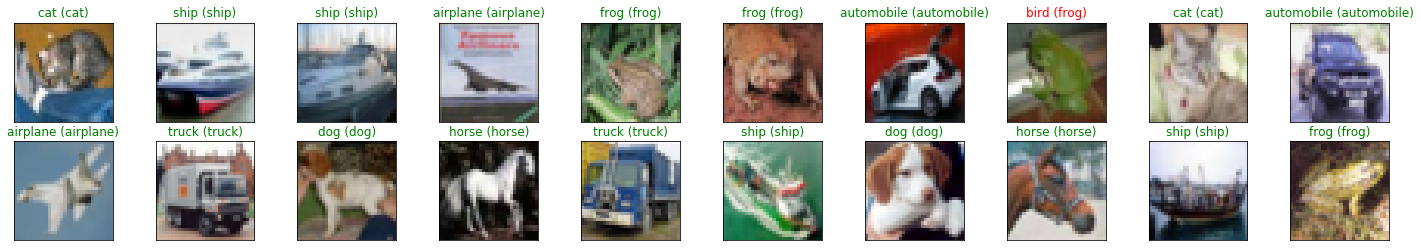

In [15]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))